In [1]:
batch_size = 4000
lr = 0.002
num_epoch = 500
number_of_features = 41
number_of_class_attack_cat = 10
number_of_class_label = 2
hyper_parameter1=128
hyper_parameter2=64
hyper_parameter3=32
hyper_parameter4=16

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.data.dataset import Dataset
from torch.utils.data import random_split, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt

# GPU OR CPU
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU")
else:
    device = torch.device("cpu")
    print("CPU")

GPU


In [4]:
UNSW_NB15 = pd.read_csv("/content/drive/MyDrive/datasets/UNSW-NB15/UNSW_NB15.csv")


indexAge = UNSW_NB15[(UNSW_NB15['attack_cat'] == 'Normal') | (UNSW_NB15['attack_cat'] == 'Generic') | (UNSW_NB15['attack_cat'] == 'Fuzzers') | (UNSW_NB15['attack_cat'] == 'Worms') | (UNSW_NB15['attack_cat'] == 'Exploits') | (UNSW_NB15['attack_cat'] == 'Reconnaissance') | (UNSW_NB15['attack_cat'] == 'Shellcode')].index
UNSW_NB15.drop(indexAge , inplace=True)

UNSW_NB15_category = UNSW_NB15.copy()
UNSW_NB15_label = UNSW_NB15.copy()

UNSW_NB15

,Unnamed: 0,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
47911,47911,47912,0.000009,ddp,-,INT,2,0,200,0,...,1,4,0,0,0,2,4,0,Backdoor,1
47912,47912,47913,0.000009,ipv6-frag,-,INT,2,0,200,0,...,2,7,0,0,0,2,7,0,Backdoor,1
47913,47913,47914,0.000009,cftp,-,INT,2,0,200,0,...,1,6,0,0,0,1,6,0,Backdoor,1
47914,47914,47915,0.000003,wsn,-,INT,2,0,200,0,...,2,7,0,0,0,2,6,0,Backdoor,1
47915,47915,47916,0.000008,pvp,-,INT,2,0,200,0,...,1,4,0,0,0,11,4,0,Backdoor,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241082,241082,65742,0.000004,unas,-,INT,2,0,200,0,...,4,4,0,0,0,8,11,0,DoS,1
241098,241098,65758,1.159325,tcp,-,FIN,26,24,3448,3188,...,1,1,0,0,0,2,1,0,DoS,1
241116,241116,65776,0.656699,tcp,-,FIN,10,8,830,1016,...,1,1,0,0,0,8,9,0,DoS,1
241120,241120,65780,0.235270,tcp,-,FIN,10,8,762,960,...,1,1,0,0,0,1,1,0,DoS,1


In [5]:
class DataSet_UNSWNB15_attack_cat(Dataset):

    def __init__(self,csv_df):
        df = csv_df
        print(df.attack_cat.value_counts().sort_values().plot(kind = "barh"))
        print(df['attack_cat'].value_counts())

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","label"], axis=1, inplace=True)        
        cols = ['attack_cat' ,'proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)
        print(df['attack_cat'].value_counts())

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
      
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

        
class DataSet_UNSWNB15_label(Dataset):

    def __init__(self, csv_path):
        df = csv_path
        print(df.label.value_counts().sort_values().plot(kind = "pie"))

        # preprocceing
        df.drop(['id',"Unnamed: 0","service","attack_cat"], axis=1, inplace=True)
        cols = ['proto' ,'state']
        df[cols] = df[cols].apply(LabelEncoder().fit_transform)

        self.data_array = df.values
        self.x = self.data_array[:, :41]
        self.y = self.data_array[:, 41]
        
        # normalaized data
        scaler = preprocessing.StandardScaler().fit(self.x)
        self.x = scaler.transform(self.x)

        self.x = torch.tensor(self.x).float()
        self.y = torch.tensor(self.y).long()

    def __len__(self):
        return len(self.data_array)

    def __getitem__(self, item):
        sample = (self.x[item, :], self.y[item])
        return sample

Axes(0.125,0.11;0.775x0.77)
DoS         16353
Analysis     2677
Backdoor     2329
Name: attack_cat, dtype: int64
2    16353
0     2677
1     2329
Name: attack_cat, dtype: int64


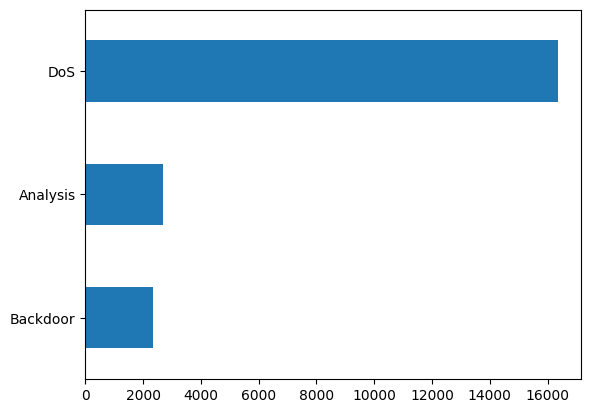

In [6]:
dataset_attack_cat = DataSet_UNSWNB15_attack_cat(UNSW_NB15_category)

number_of_test = int(len(dataset_attack_cat)*0.3)
number_of_train = len(dataset_attack_cat) - int(len(dataset_attack_cat)*0.3)
train_attack_cat ,test_attack_cat = random_split(dataset=dataset_attack_cat, lengths=[number_of_train,number_of_test])

train_attack_cat_dataloader = DataLoader(dataset=train_attack_cat ,batch_size=batch_size ,shuffle=True)
test_attack_cat_dataloader = DataLoader(dataset=test_attack_cat ,batch_size=batch_size ,shuffle=True)

Axes(0.22375,0.11;0.5775x0.77)


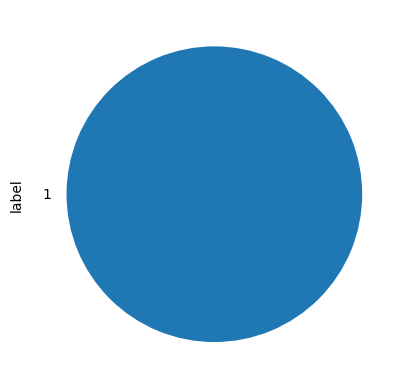

In [7]:
dataset_label = DataSet_UNSWNB15_label(UNSW_NB15_label)
number_of_test = int(len(dataset_label)*0.3)
number_of_train = len(dataset_label) - int(len(dataset_label)*0.3)
train_label ,test_label = random_split(dataset=dataset_label, lengths=[number_of_train,number_of_test])

train_label_dataloader = DataLoader(dataset=train_label ,batch_size=batch_size ,shuffle=True)
test_label_dataloader = DataLoader(dataset=test_label ,batch_size=batch_size ,shuffle=True)

In [8]:
class Model_Attack_Cat(nn.Module):

    def __init__(self):
        super(Model_Attack_Cat, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_attack_cat)
        )

    def forward(self,x):
        return self.layers(x)

class Model_Label(nn.Module):

    def __init__(self):
        super(Model_Label, self).__init__()

        self.layers = nn.Sequential(
        nn.Linear(number_of_features, hyper_parameter1),
        nn.Tanh(),
        nn.Linear(hyper_parameter1, hyper_parameter2),
        nn.Tanh(),
        nn.Linear(hyper_parameter2, hyper_parameter3),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter3, hyper_parameter4),
        nn.Sigmoid(),
        nn.Linear(hyper_parameter4,number_of_class_label)
        )
      

    def forward(self,x):
         return self.layers(x)

In [9]:
my_model_attack = Model_Attack_Cat().to(device=device)
my_model_attack

Model_Attack_Cat(
  (layers): Sequential(
    (0): Linear(in_features=41, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): Sigmoid()
    (8): Linear(in_features=16, out_features=10, bias=True)
  )
)

In [10]:
loss_fn1 = nn.CrossEntropyLoss()
loss_fn2 = nn.CrossEntropyLoss()
optimizer1 = opt.Adam(params=my_model_attack.parameters(),lr=lr)


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# **train attack cat**

In [12]:
loss_plot = list()

for epoch in range(num_epoch+1):

    for batch_x, batch_y in train_attack_cat_dataloader:

        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer1.zero_grad()
        loss1 = loss_fn1(my_model_attack(batch_x),batch_y)
        loss1.backward()
        optimizer1.step()

    if epoch % 50 == 0:
        print("loss : %.4f" % (loss1.item()))
        loss_plot.append(loss1.item())



loss : 2.4573
loss : 0.6997
loss : 0.6414
loss : 0.5900
loss : 0.5941
loss : 0.5661
loss : 0.5862
loss : 0.5795
loss : 0.5730
loss : 0.5721
loss : 0.5689


# **test attack cat**

In [13]:
correct = 0
y_test, yhat = list(), list()

for batch_x, labl in test_attack_cat_dataloader:
  
    batch_x = batch_x.to(device)
    labl = labl.to(device)
  
    out = my_model_attack(batch_x)
    _,predicted = torch.max(out,1)
    correct += torch.sum(predicted == labl)
    print(batch_x)
    print(out)
    print(labl)
    print(predicted)
    print("--------------")
    
    for i in labl.cpu().detach().numpy():
        y_test.append(i)
    for i in predicted.cpu().detach().numpy():
        yhat.append(i)


print("acc : %.2f" % (100.*correct / len(test_attack_cat)),end="")
print("%")

tensor([[-0.2356,  0.7209,  0.4489,  ..., -0.4786,  0.6202,  0.0000],
        [-0.0886, -0.4504,  0.4489,  ..., -0.4786, -0.2151,  0.0000],
        [-0.2356, -2.6128,  0.4489,  ...,  0.8988, -0.4935,  0.0000],
        ...,
        [-0.2356,  0.7209,  0.4489,  ..., -0.6754,  0.0634,  0.0000],
        [-0.2356, -0.4204,  0.4489,  ...,  0.8988,  1.4555,  0.0000],
        [-0.2356,  0.7810,  0.4489,  ..., -0.2819,  0.0634,  0.0000]],
       device='cuda:0')
tensor([[ 2.4030,  2.4155,  4.3939,  ..., -4.4216, -4.5021, -4.6401],
        [ 1.6676,  2.8030,  4.3727,  ..., -4.2365, -4.4114, -4.4681],
        [ 1.8609,  2.4874,  4.4539,  ..., -4.3558, -4.4678, -4.5513],
        ...,
        [ 2.4658,  2.2234,  4.4213,  ..., -4.4528, -4.5082, -4.6553],
        [ 3.8311,  3.6237,  3.9006,  ..., -4.3688, -4.5004, -4.7443],
        [ 2.3447,  2.3299,  4.4393,  ..., -4.4490, -4.5198, -4.6504]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([2, 2, 2,  ..., 2, 2, 0], device='cuda:0')
tensor([

Confusion matrix, without normalization
[[4743   71   84]
 [ 558   78   65]
 [ 572   33  203]]


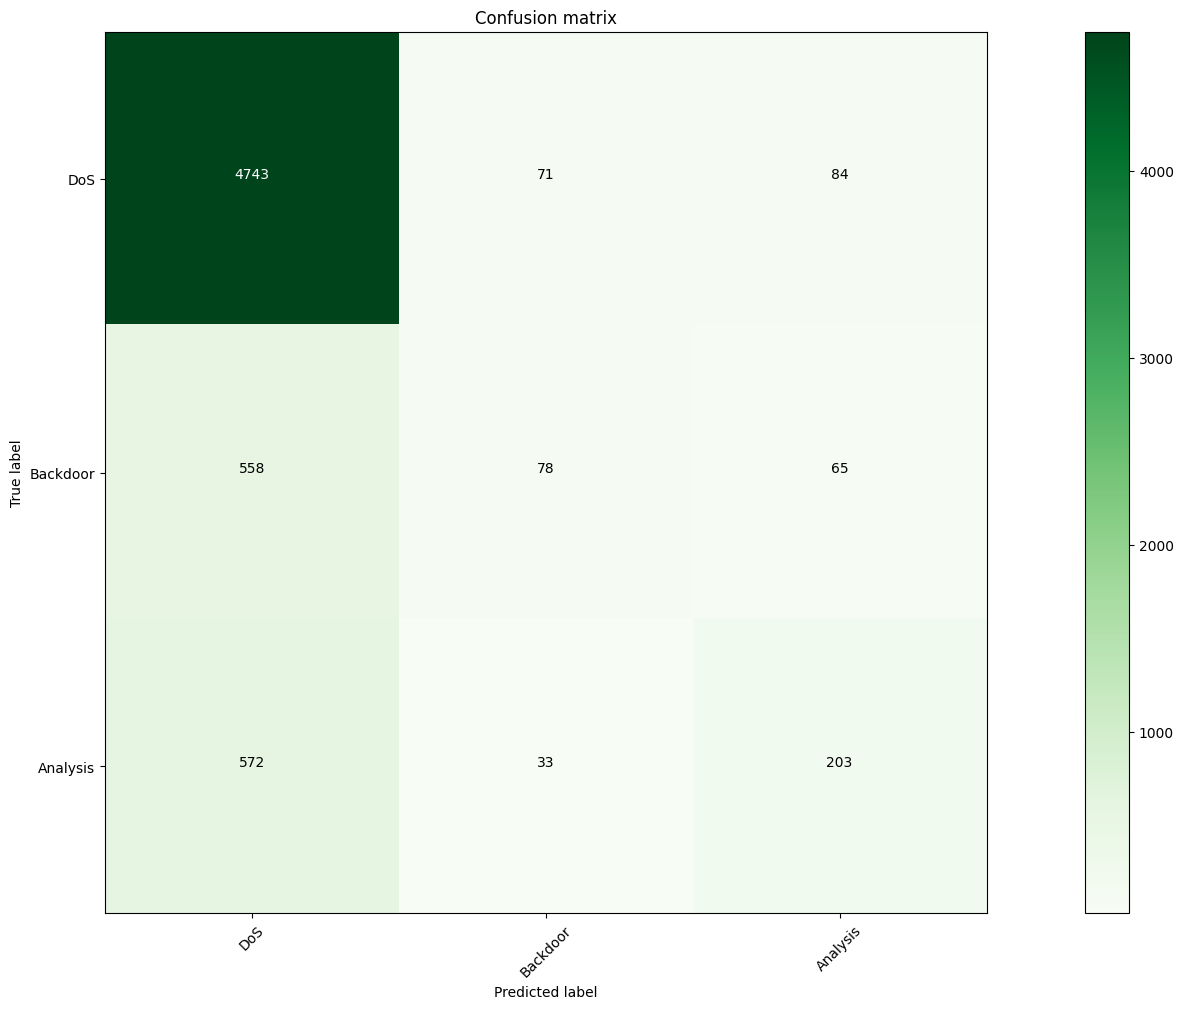

In [14]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=['DoS','Backdoor','Analysis'],normalize= False,  title='Confusion matrix')

In [15]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.58      0.25      0.35       808
           1       0.43      0.11      0.18       701
           2       0.81      0.97      0.88      4898

    accuracy                           0.78      6407
   macro avg       0.60      0.44      0.47      6407
weighted avg       0.74      0.78      0.74      6407

